___
# <span style="color:red"> **PROJET CYCLE-GAN POUR ADAPTATION DE DOMAINE (MNIST -> SVHN)** </span>
___

Dans la première partie nous avons entrainé le génrateur de SVHN.

L'usage de ce résultat va se faire dans cette partie ; ou la génération va servir de base d'entraînement pour un CNN.

___
## <span style="color:red"> **Librairie en usage pour le projet**
___

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

import imageio

import os

from tqdm import tqdm


___
## <span style="color:red"> **PARTIE 2 : Entrainnement d'un CNN avec la génration de MNIST -> SVHN** </span>
___

___
### <span style="color:red"> **II.I BLOCK CONV & DECONV**
___

In [4]:
def conv(in_chan, out_chan, kern_size, stride = 2, pad = 1, bn=True):
    
    layers = []
    
    layers.append(nn.Conv2d(in_chan, out_chan, kern_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(out_chan))

    return nn.Sequential(*layers)

In [5]:
def deconv(in_chan, out_chan, kern_size, stride = 2, pad = 1, bn = True):

    layers = []

    layers.append(nn.ConvTranspose2d(in_chan, out_chan, kern_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(out_chan))

    return nn.Sequential(*layers)


___
### <span style="color:red"> **II.II. GENERATOR**
___

In [6]:
class GeneratorMNISTtoSVHN(nn.Module):
    def __init__(self, conv_dim = 64):

        super(GeneratorMNISTtoSVHN, self).__init__()

        # Encoding Block
        self.conv1 = conv(in_chan = 1, out_chan = conv_dim, kern_size = 4)
        self.conv2 = conv(in_chan = conv_dim, out_chan = conv_dim*2, kern_size = 4)

        # Residual Block
        self.conv3 = conv(in_chan = conv_dim*2, out_chan = conv_dim*2, kern_size = 3, stride = 1, pad=1)
        self.conv4 = conv(in_chan = conv_dim*2, out_chan = conv_dim*2, kern_size = 3, stride = 1, pad=1)

        # Decoder Block
        self.deconv1 = deconv(in_chan = conv_dim*2, out_chan = conv_dim, kern_size = 4)
        self.deconv2 = deconv(in_chan = conv_dim, out_chan = 3, kern_size = 4, bn = False)

    def forward(self, x):
        # Encode
        x = F.leaky_relu(self.conv1(x), 0.05)
        x = F.leaky_relu(self.conv2(x), 0.05)
        
        # Residual
        x = F.leaky_relu(self.conv3(x), 0.05)
        x = F.leaky_relu(self.conv4(x), 0.05)

        # Decode 
        x = F.leaky_relu(self.deconv1(x), 0.05)
        x = torch.tanh(self.deconv2(x))

        return x

In [7]:
class GeneratorSVHNtoMNIST(nn.Module):
    def __init__(self, conv_dim = 64):

        super(GeneratorSVHNtoMNIST, self).__init__()

        # Encoding Block
        self.conv1 = conv(in_chan = 3, out_chan = conv_dim, kern_size = 4)
        self.conv2 = conv(in_chan = conv_dim, out_chan = conv_dim*2, kern_size = 4)

        # Residual Block
        self.conv3 = conv(in_chan = conv_dim*2, out_chan = conv_dim*2, kern_size = 3, stride = 1, pad=1)
        self.conv4 = conv(in_chan = conv_dim*2, out_chan = conv_dim*2, kern_size = 3, stride = 1, pad=1)

        # Decoder Block
        self.deconv1 = deconv(in_chan = conv_dim*2, out_chan = conv_dim, kern_size = 4)
        self.deconv2 = deconv(in_chan = conv_dim, out_chan = 1, kern_size = 4, bn = False)

    def forward(self, x):
        # Encode
        x = F.leaky_relu(self.conv1(x), 0.05)
        x = F.leaky_relu(self.conv2(x), 0.05)
        
        # Residual
        x = F.leaky_relu(self.conv3(x), 0.05)
        x = F.leaky_relu(self.conv4(x), 0.05)

        # Decode 
        x = F.leaky_relu(self.deconv1(x), 0.05)
        x = torch.tanh(self.deconv2(x))

        return x

___
### <span style="color:red"> **II.III LOAD DES MODELS & DES MNISTS**
___

On charge les models

In [8]:
PATH = "CycleGan/SaveModel/40000-gMtoS.pkl"
PATH2 = "CycleGan/SaveModel/40000-gStoM.pkl"

In [9]:
model_gen_S = GeneratorMNISTtoSVHN()
model_gen_S.load_state_dict(torch.load(PATH, map_location='cpu'))

<All keys matched successfully>

In [10]:
model_gen_M = GeneratorSVHNtoMNIST()
model_gen_M.load_state_dict(torch.load(PATH2, map_location='cpu'))

<All keys matched successfully>

On charge MNIST

In [11]:
transform = transforms.Compose([
transforms.Resize(32),
transforms.ToTensor(),
# transforms.Normalize(mean=[0.5], std=[0.5])
]
)

mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transform)

mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                    batch_size=64,
                                    shuffle=True,
                                    num_workers=2)


In [12]:
iter_test = iter(mnist_test_loader)

In [13]:
iter_mnist_test, labels_test = iter_test.next()

new_gen = model_gen_S(iter_mnist_test)

retransform = model_gen_M(new_gen)

On test nos models sur MNIST Test par le cycle suivant : MNIST -> SVHN -> MNIST

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2)
tensor(0)
tensor(1)
tensor(9)
tensor(4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(7)
tensor(8)
tensor(6)
tensor(3)
tensor(1)


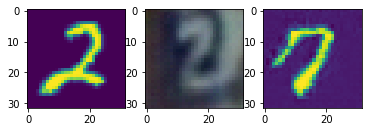

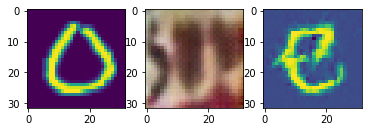

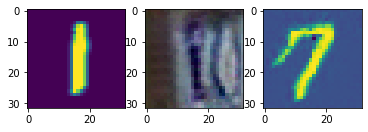

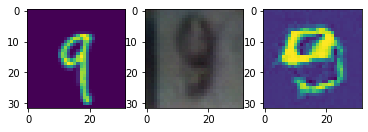

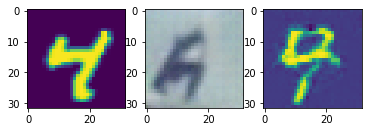

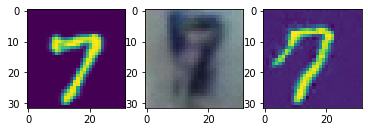

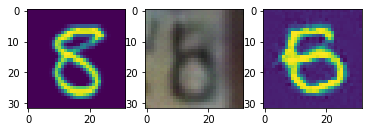

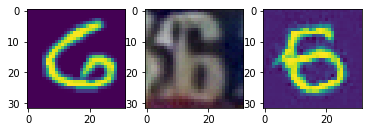

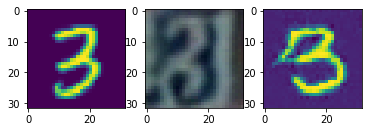

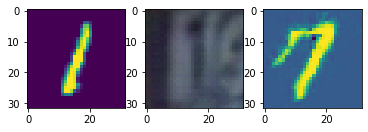

In [14]:
n = 10

for i in range(n):

    print(labels_test[i])
    images_origine = np.transpose(iter_mnist_test[i].detach().numpy(), [1,2,0]) 
    images = np.transpose(new_gen[i].detach().numpy(), [1,2,0]) 
    retransform_im = np.transpose(retransform[i].detach().numpy(), [1,2,0]) 
    
    f, axs = plt.subplots(1,3)
    axs[0].imshow(images_origine)
    axs[1].imshow(images)
    axs[2].imshow(retransform_im)
    

On peut considerer les résultats comme acceptable.

___
### <span style="color:red"> **II.IV TRAINNING ON FAKE SVHN**
___

In [15]:
def conv2(in_chan, out_chan, kern_size, bn=True):
    
    layers = []
    
    layers.append(nn.Conv2d(in_chan, out_chan, kern_size, stride=1, padding="same"))
    if bn:
        layers.append(nn.BatchNorm2d(out_chan))


    return nn.Sequential(*layers)

In [16]:
# MNIST DISCRIMINATOR

class CNN(nn.Module):
    def __init__(self, conv_dim = 32):
        
        super(CNN, self).__init__()

        # on alterne les conv avec BatchNorm & MaxPooling

        self.conv1 = conv2(in_chan = 3, out_chan = conv_dim, kern_size = 3)
        self.conv2 = conv2(in_chan = conv_dim, out_chan = conv_dim, kern_size = 3, bn = False)
        self.conv3 = conv2(in_chan = conv_dim, out_chan = conv_dim*2, kern_size = 3)
        self.conv4 = conv2(in_chan = conv_dim*2, out_chan = conv_dim*2, kern_size = 3, bn = False)
        self.conv5 = conv2(in_chan = conv_dim*2, out_chan = conv_dim*4, kern_size = 3)
        self.conv6 = conv2(in_chan = conv_dim*4, out_chan = conv_dim*4, kern_size = 3, bn = False)

        # Classif

        self.fc = nn.Linear(4*4*128, 128)

            # Dropout number
        self.dropout = nn.Dropout(0.4)

        self.fc1 = nn.Linear(128, 10)

        self.softmax = nn.Softmax(0)


    def forward(self,x):

        # Convolution

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x)) 
        x = F.max_pool2d(input = x, kernel_size = (2,2))
        
        x = F.relu(self.conv3(x)) 
        x = F.relu(self.conv4(x)) 
        
        x = F.max_pool2d(input = x, kernel_size = (2,2))

        
        x = F.relu(self.conv5(x)) 

        x = F.relu(self.conv6(x)) 

        x = F.max_pool2d(input = x, kernel_size = (2,2))


        # Classif


        x = torch.flatten(x, start_dim=1)
        
        x = F.relu(self.fc(x))

        x = self.dropout(x)

        x = self.fc1(x)

        x = self.softmax(x)


        
        return x


In [17]:
model = CNN()

In [18]:
model

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv6): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (fc): Linear(in_features=2048, out_features=128, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_f

In [19]:
LEARNING_RATE = 2.e-4

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [21]:
def train(model, convert, optimizer, mnist_test_loader,criterion,  EPOCH):
  

  for epoch in range(EPOCH) :

    running_loss = 0.0

    mnist_test_load = iter(mnist_test_loader)

    iter_per_epoch = len(mnist_test_load)
    

    # loop over the data iterator, and feed the inputs to the network and adjust the weights.
    acc = 0.0

    for step in tqdm(range(iter_per_epoch)):
      
      inputs, labels = mnist_test_load.next() 


      convert_inputs = convert(inputs)

      

      # zero param
      optimizer.zero_grad()

      # forward, backward, optimize
      outputs = model(convert_inputs)


      loss = criterion(outputs, labels)

      loss.backward()

      optimizer.step()

      running_loss += loss.item()

      acc += calc_accuracy(mdl = model, X = convert_inputs, Y = labels) 

    

    print(f'[{epoch + 1} / {EPOCH:5d}] => loss: {running_loss / len(mnist_test_loader):.3f} and Accuracy = {acc/157:2f}')
    
      

  print('Finished Training')
    

In [22]:
def calc_accuracy(mdl, X, Y ) :
    """
    Get the accuracy with respect to the most likely label

    :param mdl:
    :param X:
    :param Y:
    :return:
    """
    y_logits = mdl(X)  

    torch.sum(y_logits.argmax(1) == Y)

    acc = torch.sum(y_logits.argmax(1) == Y) / len(X)

    return acc

In [23]:
train(model = model, convert = model_gen_S , optimizer = optimizer, mnist_test_loader= mnist_test_loader,criterion= criterion,  EPOCH = 20)

100%|██████████| 157/157 [03:09<00:00,  1.20s/it]

[1 /    20] => loss: 2.227 and Accuracy = 0.419188



100%|██████████| 157/157 [03:08<00:00,  1.20s/it]

[2 /    20] => loss: 2.178 and Accuracy = 0.600717



100%|██████████| 157/157 [03:08<00:00,  1.20s/it]

[3 /    20] => loss: 2.174 and Accuracy = 0.642018



100%|██████████| 157/157 [03:09<00:00,  1.21s/it]

[4 /    20] => loss: 2.172 and Accuracy = 0.667795



100%|██████████| 157/157 [03:09<00:00,  1.21s/it]

[5 /    20] => loss: 2.171 and Accuracy = 0.707803



100%|██████████| 157/157 [03:09<00:00,  1.20s/it]

[6 /    20] => loss: 2.169 and Accuracy = 0.755971



100%|██████████| 157/157 [03:09<00:00,  1.21s/it]

[7 /    20] => loss: 2.169 and Accuracy = 0.783440



100%|██████████| 157/157 [03:09<00:00,  1.20s/it]

[8 /    20] => loss: 2.168 and Accuracy = 0.780852



100%|██████████| 157/157 [03:08<00:00,  1.20s/it]

[9 /    20] => loss: 2.167 and Accuracy = 0.815486



100%|██████████| 157/157 [03:08<00:00,  1.20s/it]

[10 /    20] => loss: 2.169 and Accuracy = 0.792396



100%|██████████| 157/157 [03:08<00:00,  1.20s/it]

[11 /    20] => loss: 2.168 and Accuracy = 0.814690



100%|██████████| 157/157 [03:09<00:00,  1.20s/it]

[12 /    20] => loss: 2.167 and Accuracy = 0.831907



100%|██████████| 157/157 [03:08<00:00,  1.20s/it]

[13 /    20] => loss: 2.166 and Accuracy = 0.868830



100%|██████████| 157/157 [03:08<00:00,  1.20s/it]

[14 /    20] => loss: 2.166 and Accuracy = 0.886943



100%|██████████| 157/157 [03:08<00:00,  1.20s/it]

[15 /    20] => loss: 2.166 and Accuracy = 0.894705



100%|██████████| 157/157 [03:08<00:00,  1.20s/it]

[16 /    20] => loss: 2.166 and Accuracy = 0.884455



100%|██████████| 157/157 [03:08<00:00,  1.20s/it]

[17 /    20] => loss: 2.166 and Accuracy = 0.876592



100%|██████████| 157/157 [03:08<00:00,  1.20s/it]

[18 /    20] => loss: 2.167 and Accuracy = 0.899184



100%|██████████| 157/157 [03:08<00:00,  1.20s/it]

[19 /    20] => loss: 2.164 and Accuracy = 0.922671



100%|██████████| 157/157 [03:08<00:00,  1.20s/it]

[20 /    20] => loss: 2.165 and Accuracy = 0.919486
Finished Training


On load SVHN Test pour tester le CNN.

In [24]:
### LOAD SVHN TEST ###
###################### 

transform = transforms.Compose([
transforms.Resize(32),
transforms.ToTensor(),
# transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
]
)

svhn = datasets.SVHN(root='data', split = 'test', download=True, transform=transform)

svhn_loader = torch.utils.data.DataLoader(dataset=svhn,
                                    batch_size=64,
                                    shuffle=True,
                                    num_workers=2)



Using downloaded and verified file: data/test_32x32.mat


On applique notre classification sur l'ensemble des batchs pour avoir une bonne idée du résultat final.

on stocke les prédictions dans perdent et les labels associés dans labl.

In [25]:
svhn_iter_test = iter(svhn_loader)

pred = []
labl = []

for i in tqdm(range(len(svhn_iter_test))):    
    data_svhn, label_svhn = svhn_iter_test.next()

    pred.append((model(data_svhn).argmax(1)).numpy())
    labl.append(label_svhn.numpy())




100%|██████████| 407/407 [00:58<00:00,  6.90it/s]


In [26]:
pred = np.concatenate( pred, axis=0 )
labl = np.concatenate( labl, axis=0 )


In [27]:
print("Le résultat de l'accuracy est : ", sum(pred==labl)/len(pred))

Le résultat de l'accuracy est :  0.3141902274124155


Le résultat final est de 30,8 % ce qui n'estvraiment pas trés performants. 

On cherche à observer la matrice de confusion pour observer ou sont les bon résultats des mauvais.

In [30]:
import sklearn.metrics as skm 
import seaborn as sns
import matplotlib.pyplot as plt 

In [31]:
confusion_mat = skm.confusion_matrix(labl, pred)

<AxesSubplot:>

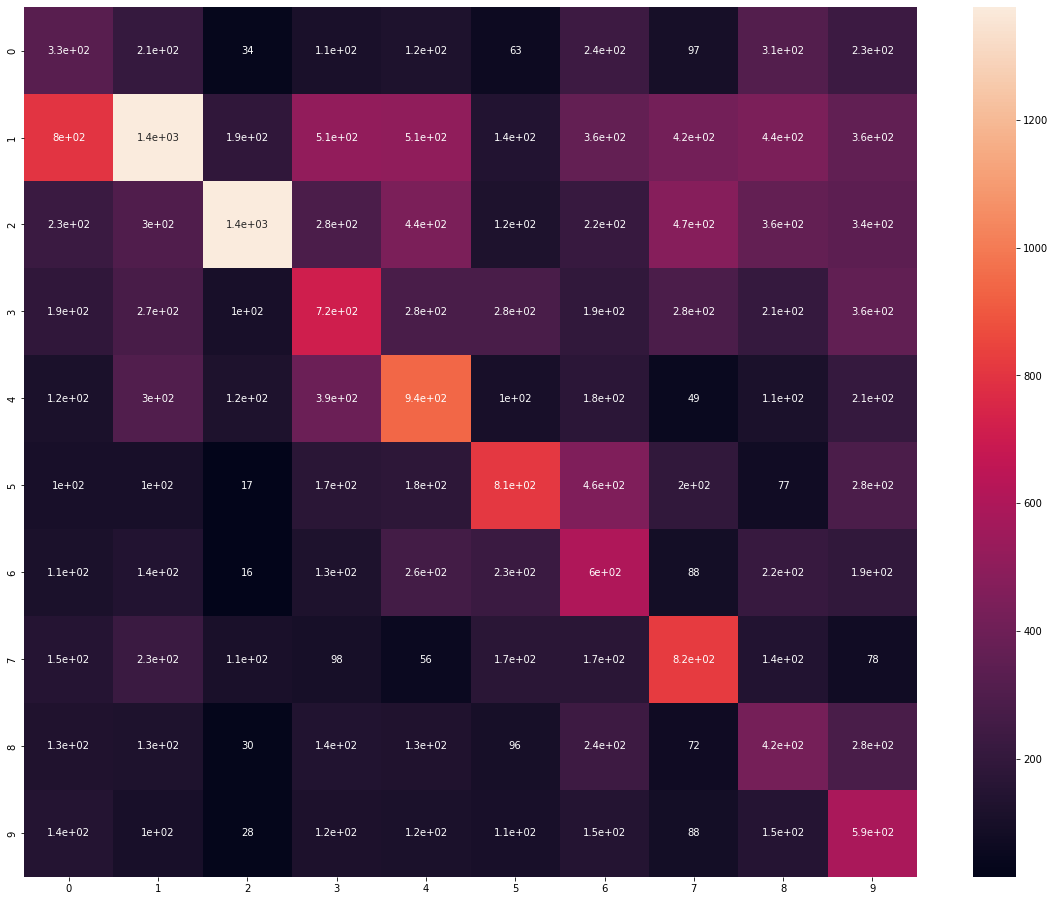

In [33]:
plt.figure(figsize = (20,16))

sns.heatmap(confusion_mat, annot=True)


Dans le papier de ***Asymmetric Tri-training for Unsupervised Domain Adaptation*** de ***Kuniaki Saito, Yoshitaka Ushiku,  Tatsuya Harada*** le résultat obtenu est de 53 % biens loin de nos 31 %.

Néanmoins on observe que le résultat est beaucoup moins bon qu'avec le jeu de données d'origine pour le train (96%).

<center>
<img src="../Images/Result-s-o-a.png" width="800" >  
</center>